In [1]:
import lxml
from absl import app, flags, logging
from absl.flags import FLAGS
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from chars_cut import cut
from chars_detect import detect
from chars_model import CModel
from generate_dataset_plate import parse_xml
from plate_detect import detect_and_cut_single_img, cut_plate
from tools.dataset_utils import generate_xml
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
import yolov3_tf2.dataset_chars as dataset
import os
import matplotlib.pyplot as plt
import cv2
from scipy import signal
import scipy.stats as st

def gkern(kernlen, N=5, sigma=None):
    """Returns a 2D Gaussian kernel."""
    if sigma is None:
        sigma = np.sqrt(kernlen/N)
    x = np.linspace(-sigma, sigma, kernlen)
    return st.norm.pdf(x)*2

In [2]:
def rush_forward(pos, array, step):
    while pos+step < array.shape[0] and array[pos] > array[pos+step]:
        pos += step
    return pos

def rush_backward(pos, array, step):
    while pos-step>=0 and array[pos-step] < array[pos]:
        pos -= step
    return pos

def rush_b(ret_l, ret_r, array, step=1, minimum=0):
    l, r = ret_l, ret_r
    ret_l = rush_backward(ret_l, array, step)
    ret_l = rush_forward(ret_l, array, step)
    ret_r = rush_forward(ret_r, array, step)
    ret_r = rush_backward(ret_r, array, step)
    if ret_r - ret_l < minimum:
        return l, r
    return ret_l, ret_r
    
def find_half_bogu_area(array, lmb=6):
    #array = np.diff(np.diff(array))
    #l, r = np.min(array), np.max(array)
    mid = l = r = int(np.max(array) / lmb)
    r += 10
    ret_l, ret_r = 0, array.shape[0] - 1
    while l < r:
        mid = (l+r+1) // 2
        tmp = np.diff(array>mid)
        poses = np.argwhere(tmp==1).flatten()
        if poses.shape[0] < 2:
            r = mid - 1
            continue
        d = np.diff(poses)
        pos = d.argmax()
        tmp_l, tmp_r = rush_b(poses[pos], poses[pos+1], array)
        if d[pos] > array.shape[0] * 0.4:
            ret_l, ret_r = tmp_l, tmp_r
            l = mid
        else:
            r = mid - 1
            pass
        pass
    print('MID:', l)
    print(ret_l, ret_r)
    ret_l, ret_r = rush_b(ret_l, ret_r, array)
    print(ret_l, ret_r)
    return ret_l, ret_r

In [3]:
flags.DEFINE_string('image_root_path', './data/Plate_dataset/AC/train/jpeg/', 'path to input image')
flags.DEFINE_string('xml_in_root_path', './data/Plate_dataset/AC/train/xml/', 'path to input xml')
flags.DEFINE_string('xml_out_root_path', './data/Plate_dataset/AC/test/xml_pred/', 'path to output xml')
flags.DEFINE_string('classifier_classes', './data/chars_data.names', 'path to classes file')
flags.DEFINE_string('classifier_weights', './chars_checkpoints/resnet101v2_train_98.tf', 'path to weights file')
flags.DEFINE_integer('classifier_size', 32, 'size of each character should be resize to')

app._run_init(['cut'], app.parse_flags_with_usage)

['cut']

In [5]:
class_map_inv = {idx: name for idx, name in enumerate(open(FLAGS.classifier_classes).read().splitlines())}
class_num = len(class_map_inv)
model = CModel(size=FLAGS.classifier_size, class_num=class_num, weights=None)
model.load_weights(FLAGS.classifier_weights).expect_partial()

In [6]:
xmls = [filename for filename in os.listdir(FLAGS.xml_in_root_path) if filename.endswith('.xml')]

In [16]:
xml = '1.xml'
annotation_xml = lxml.etree.fromstring(open(os.path.join(FLAGS.xml_in_root_path, xml)).read())
annotation = parse_xml(annotation_xml)['annotation']
img_file_name = annotation['filename']
img_path = os.path.join(FLAGS.image_root_path, img_file_name)
xmin = int(annotation['object'][0]['bndbox']['xmin'])
ymin = int(annotation['object'][0]['bndbox']['ymin'])
xmax = int(annotation['object'][0]['bndbox']['xmax'])
ymax = int(annotation['object'][0]['bndbox']['ymax'])

In [17]:
def bw_process(img, a=199, b=6):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    equ = cv2.equalizeHist(img_grey)
    img_bw = cv2.adaptiveThreshold(equ, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, a, b)
    #img_bw = cv2.adaptiveThreshold(equ, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 11)
    img_bw = 255 - img_bw
    return img_bw

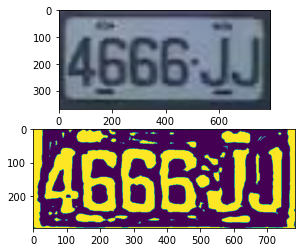

In [18]:
img_raw = img_rawer = tf.image.decode_jpeg(open(img_path, 'rb').read())
img_rawer = cut_plate(img_rawer, xmin, ymin, xmax, ymax)
delta_00 = int(img_raw.shape[0] * 0.16)
delta_01 = int(img_raw.shape[0] * 0.15)
delta_10 = int(img_raw.shape[1] * 0.00)
delta_11 = int(img_raw.shape[1] * 0.02)
img_raw = img_rawer[delta_00:img_rawer.shape[0]-delta_01, delta_10:img_rawer.shape[1]-delta_11]
img_bw = bw_process(img_raw,a=99,b=6)
img_bw_bak = bw_process(img_raw, a=199, b=10)
plt.subplot(2,1,1).imshow(img_rawer)
plt.subplot(2,1,2).imshow(img_bw)

In [19]:
letter_k = []
copy_img = img_bw.copy()
contours, hierarchy = cv2.findContours(copy_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
y_min = img_bw.shape[0]
y_max = 0
hs = []
ws = []
for cnt in contours:
    if cv2.contourArea(cnt) > 20:
        x,y,w,h = cv2.boundingRect(cnt)
        if h >= img_bw.shape[0] * 0.4 and w >= img_bw.shape[1] * 0.05:
            # letter_img.append(lines_img[i][y:y+h, x:x+w])
            letter_k.append((x,y,w,h))
            y_min = min(y_min, y)
            y_max = max(y_max, y+h)
            hs.append(h)
            ws.append(w)
hs = np.array(hs)
ws = np.array(ws)
h_median = np.median(hs)
w_median = np.median(ws)
hs = (hs - h_median) / np.max(hs)
ws = (ws - w_median) / np.max(ws)
print(len(letter_k))

8


True

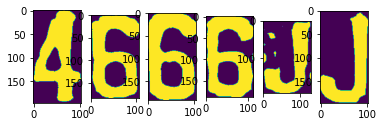

In [20]:
if len(letter_k) < 6:
    ok = False
else:
    if len(letter_k) > 6:
        letter_k = sorted(letter_k, key=lambda x: (x[3] - h_median) ** 2)[:6]
    ok = True
    letter_k = sorted(letter_k, key=lambda x: -x[2])
    while int(round(letter_k[0][2] / (img_bw.shape[1] / 7))) > 1:
        tmp = letter_k[1:]
        x, y, w, h = letter_k[0]
        tol = int(round(w / (img_bw.shape[1] / 7)))
        ww = w // tol
        for i in range(tol):
            tmp.append((x + ww * i, y, ww, h))
        letter_k = tmp
    if len(letter_k) > 6:
        letter_k = sorted(letter_k, key=lambda x: (x[3] - h_median) ** 2)[:6]
    letter_k = sorted(letter_k, key=lambda x:x[0])
    chrs = [img_bw_bak[y:y + h, x:x + w] for x, y, w, h in letter_k]
for i in range(len(chrs)):
    plt.subplot(1,len(chrs),i+1).imshow(chrs[i])
ok

6 123
136 253
266 383
396 513
526 643
656 773
[(0, 131), (132, 255), (256, 373), (372, 501), (502, 655), (654, 781)]


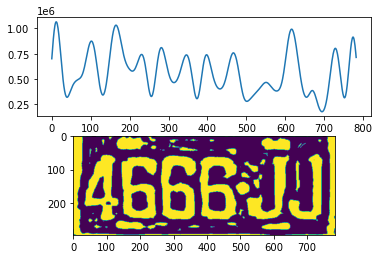

In [21]:
heng = np.sum(img_bw, axis=1).astype(np.int32)
heng = np.convolve(heng, gkern(int(img_bw.shape[0]*0.1)), 'same')
zong = np.sum(img_bw, axis=0).astype(np.int32)
#zong = gkern(img_bw.shape[0], N=4) @ img_bw
zong = np.convolve(zong, gkern(int(img_bw.shape[1]*0.1)), 'same')

lrs = []
ddd = img_bw.shape[1] // 6

for i in range(6):
    k = i * ddd + ddd // 2
    l = max(0, int(k - ddd * 0.45))
    r = min(img_bw.shape[1]-1, int(k + ddd * 0.45))
    print(l, r)
    l, r = rush_b(l, r, zong, step=2, minimum=img_bw.shape[1] / 8)
    lrs.append((l, r))
print(lrs)

plt.subplot(2,1,1).plot(zong)
plt.subplot(2,1,2).imshow(img_bw)

[(0, 115), (114, 217), (250, 359), (342, 457), (512, 635), (616, 725)]


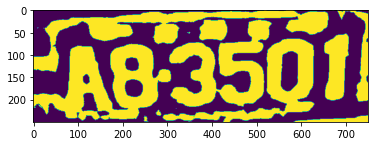

In [99]:
img_bw = bw_process(img_rawer, a=189)
chrs = [img_bw[:,l+delta_10:r+delta_10] for l,r in lrs]
print(lrs)
plt.imshow(img_bw)

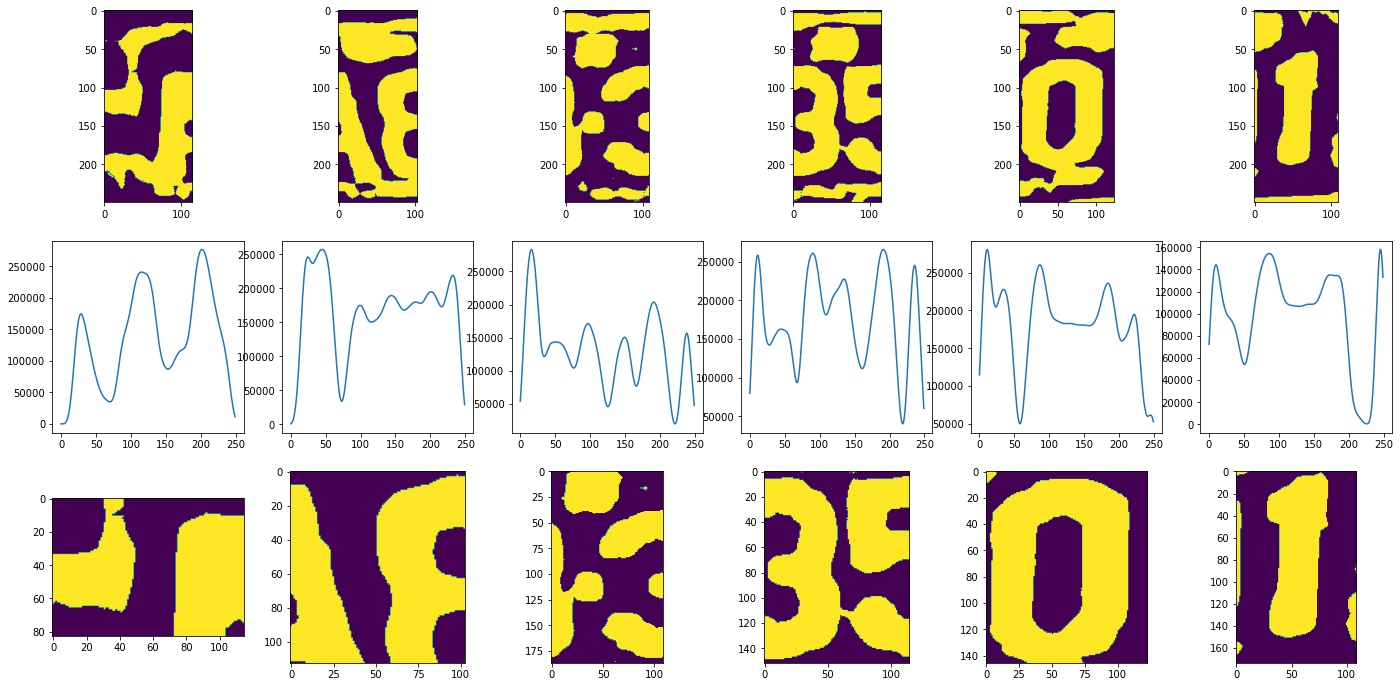

In [100]:
fx = []
plt.figure(figsize=(24,12))
for i in range(6):
    plt.subplot(3, 6, i+1).imshow(chrs[i])
    heng = np.sum(chrs[i], axis=1).astype(np.int32)
    heng = np.convolve(heng, gkern(int(chrs[i].shape[0]*0.1)), 'same')
    k = chrs[i].shape[0] // 2
    de = int(chrs[i].shape[0] * 0.3)
    u = k - de
    d = k + de
    u, d = rush_b(u, d, heng)
    plt.subplot(3, 6, i+7).plot(heng)
    plt.subplot(3, 6, i+13).imshow(chrs[i][u:d])

In [57]:
heng = np.sum(img_bw, axis=1).astype(np.int32)

MID: 8998
53 187
53 187
MID: 11612
0 133
0 133


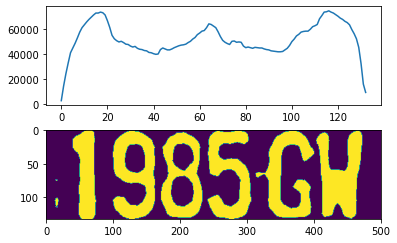

In [546]:
tmp = img_raw.copy()

img_bw = bw_process(tmp,a=199, b=60)
l, r = find_half_bogu_area(np.sum(img_bw, axis=1).astype(np.int32), lmb=8)
tmp = tmp[l:r]

img_bw = bw_process(tmp,a=155,b=34)
l, r = find_half_bogu_area(np.sum(img_bw, axis=1).astype(np.int32), lmb=6)
tmp = tmp[l:r]

img_bw_heng = bw_process(tmp, b=25)
heng = np.sum(img_bw_heng, axis=1).astype(np.int32)
plt.subplot(2,1,2).imshow(img_bw_heng)
plt.subplot(2,1,1).plot(heng)

[  0  42  94 140 226]
112363515.78123146
43 226


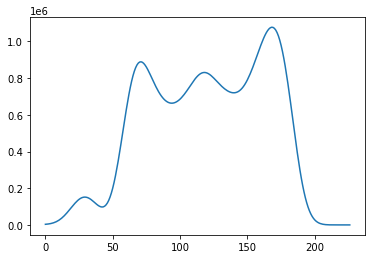

In [547]:

img_bw = bw_process(img_raw, a=199, b=40)
heng = np.sum(img_bw, axis=1).astype(np.int32)
heng = np.convolve(heng, gkern(delta), 'same')
bogu,_ = signal.find_peaks(-heng)

if len(bogu <= 1):
    bogu = np.hstack([0, bogu, img_raw.shape[0] - 1])

pheng = np.cumsum(heng)
plt.plot(heng)
print(bogu)
print(pheng[-1])
l, r = 0, img_raw.shape[0] - 1
for i in bogu:
    for j in bogu:
        if i <= img_raw.shape[0]//2 <= j and abs((j - img_raw.shape[0]//2) - (img_raw.shape[0]//2 - i)) < delta:
            if (pheng[j] - pheng[i])/pheng[-1] > 0.6:
                if r-l > j-i:
                    r, l = j, i
l, r = rush_b(l, r, np.sum(img_bw, axis=1).astype(np.int32))
img_bw_heng = bw_process(img_raw[l:r], b=10)
print(l, r)

In [548]:
signal.find_peaks(heng)

(array([ 29,  71, 118, 168]), {})

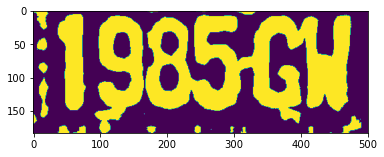

In [549]:
plt.imshow(img_bw_heng)

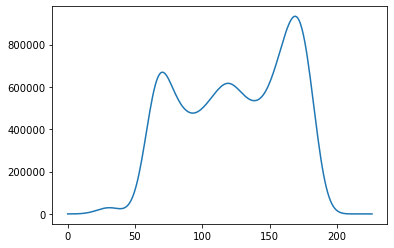

In [550]:
img_bw = bw_process(img_raw,a=199, b=60)
heng = np.sum(img_bw, axis=1).astype(np.int32)

tmp = np.convolve(heng, gkern(delta), 'same')
plt.plot(tmp)

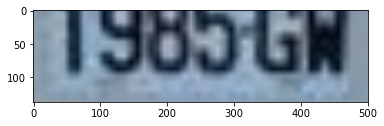

In [551]:
plt.imshow(img_raw[90:240])

In [311]:
tmp = np.argwhere(np.sum(img_bw_heng, axis=0)==0).flatten()
print(img_bw_heng.shape)

L = max([x for x in tmp if x < img_bw_heng.shape[1]//15], default=0)
R = min([x for x in tmp if (img_bw_heng.shape[1]-x) < img_bw_heng.shape[1]//15], default=img_bw_heng.shape[1]-1)
print(L,R)

(246, 710)
0 709


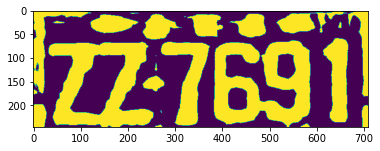

In [312]:
img_bw_heng=img_bw_heng[:,L:R]
plt.imshow(img_bw_heng)

In [ ]:
height=img_bw_heng.shape[0]
ker = 1-gkern(height)
#ker = np.ones(img_bw_heng.shape[0])
plt.plot(ker)

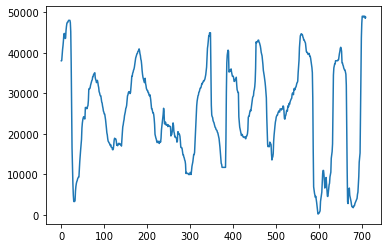

In [315]:
zong=ker@img_bw_heng
plt.plot(zong)

9


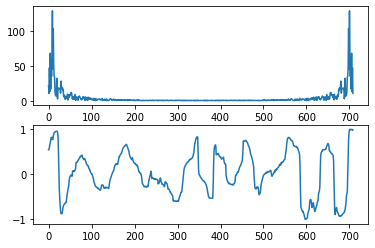

In [316]:
mx = np.max(zong)
mi = np.min(zong)
tmp = (zong - mi) / (mx - mi) * 2 - 1
fft = np.fft.fft(tmp)
plt.subplot(2,1,1).plot(np.abs(fft))
plt.subplot(2,1,2).plot(tmp)
print(np.argmax(np.abs(fft)))

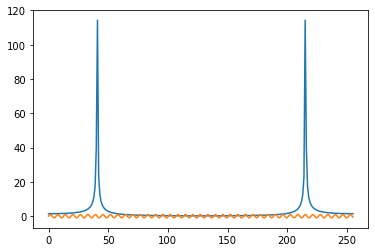

In [317]:
t = np.arange(256)
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(zong.shape[0])
plt.plot(np.abs(sp))
plt.plot(np.sin(t))

In [318]:
#plt.plot(np.sum(img_bw_heng, axis=0))

In [319]:
def get_poses_sizez(mid, zong):
    poses = np.argwhere(zong<mid).flatten()
    poses = np.hstack([0, poses, zong.shape[0]-1])
    sizez = sorted(enumerate(np.diff(poses)), key=lambda x: -x[1])
    return poses, sizez

In [320]:
def get_var(mid, zong):
    poses, sizez = get_poses_sizez(mid, zong)
    if len(sizez) < 6:
        return np.inf
    sizez = sizez[:6]
    mids = []
    delta = (sizez[0][1] + sizez[1][1])/2
    for i,j in sorted(sizez, key=lambda x: x[0]):
        mids.append((poses[i+1] + poses[i]) / 2)
    if delta * 6 < zong.shape[0] * 0.7:
        return np.inf
    fff = np.diff(mids)
    mid_var = np.square(fff - np.mean(fff)).sum()
    fff = np.array([b for a,b in sizez])
    sizez_var = np.square(fff - delta).sum()
    return mid_var * 0.2 + sizez_var *0.8

In [321]:
maximum = zong.max()
ans = (np.inf, np.inf)
for i in range(100):
    mid = maximum * i / 100
    cur = get_var(mid, zong)
    if cur < ans[0]:
        ans = (cur, mid)


In [322]:
poses, sizez = get_poses_sizez(ans[1], zong)
sizez = sizez[:6]
lrs = []
delta = (sizez[0][1] + sizez[1][1])/2
for i,j in sorted(sizez, key=lambda x: x[0]):
    l,r = rush_b(poses[i], poses[i+1], zong, step=10)
    if r-l < delta*0.7:
        mid = (l+r)/2
        l,r = max(0,int(mid-delta*0.35)), min(int(mid+delta*0.35),zong.shape[0]-1)
        l,r = rush_b(l, r, array=zong, step=8)
    lrs.append((l,r))
    #lrs.append((poses[i] ,poses[i+1]))

<ipython-input-323-765e8a285e4e>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 1).plot(np.ones(img_bw_heng.shape[1]) * ans[1])


[(36, 113), (140, 228), (228, 298), (290, 379), (382, 490), (493, 596)]


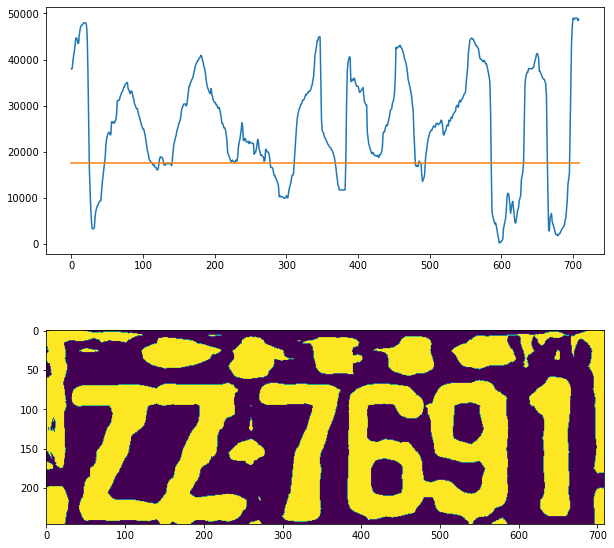

In [323]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1).plot(zong)
plt.subplot(2, 1, 1).plot(np.ones(img_bw_heng.shape[1]) * ans[1])
plt.subplot(2, 1, 2).imshow(img_bw_heng)
print(lrs)

In [324]:
#chrs = [img_bw_heng[:,max(int(mid-delta/2), 0):min(int(mid+delta/2), img_bw_heng.shape[1])] for mid in mids]
chrs = [img_bw_heng[:,l:r] for l,r in lrs]


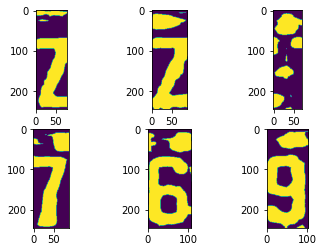

In [325]:
for idx, img in enumerate(chrs):
    plt.subplot(2, 3, idx+1).imshow(img)
    #plt.subplot(2, 3, idx+1).imshow(img_bw_heng[:,idx*img_bw_heng.shape[1]//6:(idx+1)*img_bw_heng.shape[1]//6])
    pass
plt.show()

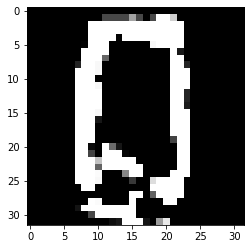

In [698]:
tmp = tf.image.resize_with_pad(tf.expand_dims(chrs[5], axis=2), 32, 32, antialias=False)
plt.imshow(tmp.numpy()[:,:,0], cmap='gray')